# Intro

This notebook will later be deleted, it is simply for testing that the script version of diva will run on the cluster.

# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../')
from diva import diva

# general imports
import warnings
import numpy as np
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.optimizers import Adam


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# programming stuff
import time
import os
import pickle
from pathlib import Path

# set seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [2]:
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
num_genes = 1000


def read_files(data_path, file_idx, file_name):
  pbmc_rep1_pseudobulk_file = os.path.join(data_path, f"{file_name}_pseudo_{file_idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(data_path, f"{file_name}_prop_{file_idx}.pkl")
  pbmc_rep1_gene_file = os.path.join(data_path, f"{file_name}_genes.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  gene_path = Path(pbmc_rep1_gene_file)

  prop_df = pickle.load( open( prop_path, "rb" ) )
  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  return (pseudobulks_df, prop_df, gene_df)

def read_all_files(data_path, idx_range, file_name):

  X_concat = None

  for idx in idx_range:
    X_train, Y_train, gene_df = read_files(data_path, idx, file_name)
    X_train.columns = gene_df["gene_ids"]

    if X_concat is None:
      X_concat, Y_concat = X_train, Y_train
    else:
      X_concat = pd.concat([X_concat, X_train])
      Y_concat = pd.concat([Y_concat, Y_train])

  return (X_concat, Y_concat, gene_df)



# get all the augmented data
X_train, Y_train, gene_df = read_all_files(aug_data_path, range(0, 12), "pbmc_rep1_10xV2a_sm2_cells")

### need to filter to genes found in smartseq2
_, _, gene_df_sm2 = read_files(aug_data_path, 0, "pbmc_rep1_sm2")
genes_common = np.intersect1d(gene_df_sm2["gene_ids"], gene_df["gene_ids"])


X_train = X_train[genes_common]
gene_df = pd.DataFrame([X_train.columns.values])
gene_df = gene_df.transpose()
gene_df.columns = ["gene_ids"]

print(Y_train.shape)
print(X_train.shape)
print(gene_df.shape)

#n_tot_samples = 12
#n_cell_types = 9

n_tot_samples = 12
n_cell_types = 6
train_file_name = "pbmc_rep1_10xV2a_sm2_cells"
n_train = 1000

(12000, 6)
(12000, 18499)
(18499, 1)


In [3]:
np.sum(Y_train, axis=1)

0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
    ... 
0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
Length: 12000, dtype: float64

In [4]:
gene_df

,gene_ids
0,ENSG00000000003_TSPAN6
1,ENSG00000000419_DPM1
2,ENSG00000000457_SCYL3
3,ENSG00000000460_C1orf112
4,ENSG00000000938_FGR
...,...
18494,ENSG00000283033_RP11-219A15.5
18495,ENSG00000283064_RP1-221C16.8
18496,ENSG00000283103_LLNLR-245B6.1
18497,ENSG00000283117_CTD-2060L22.1


# **Experimental Setup**

Now lets set up our experiments

In [5]:
##################################################
#####. Design the experiment
##################################################

## 3 is unlabeled
## we test on 0
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()



## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
X_full = X_full[:,idx_top]
gene_df = gene_df.iloc[idx_top]

## normalize within sample
X_full = scale(X_full, axis=1)
               
print(X_full.shape)

### also create the condition label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5),
                              np.full(n_train, 6), np.full(n_train, 7),
                              np.full(n_train, 8), np.full(n_train, 9),
                              np.full(n_train, 10), np.full(n_train, 11)], axis=0)
label_full = to_categorical(Label_full)

# indexes for the training, 3 and 0
idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=0))[0]
idx_3 = np.where(Label_full==2)[0]
idx_0 = np.where(Label_full==0)[0]


# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_3,]
label_unkp = label_full[idx_3,]
y_unkp = Y_full[idx_3,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test; i.e. 75 degrees
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
y_0 = Y_full[idx_0,]




/tmp/ipykernel_31420/1352047423.py:15: RuntimeWarning: invalid value encountered in true_divide
  X_CoV = np.array(np.divide(X_colvar, X_colmean))


(12000, 1000)


In [6]:
np.min(X_train.mean(axis=1))
np.max(X_train.mean(axis=1))
np.median(X_train.mean(axis=1))

40.36510323635076

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.007s...
[t-SNE] Computed neighbors for 12000 samples in 3.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.179789
[t-SNE] KL divergenc

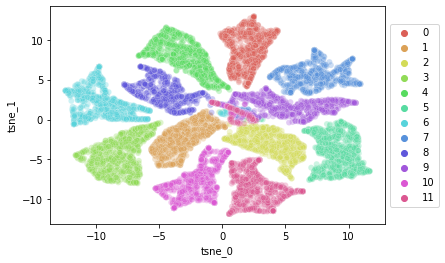

In [7]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **Model Definition**


## Hyperparameters

In [8]:
batch_size = 500
n_epoch = 500

alpha_rot = 1000000
alpha_prop = 100 

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")


length of X 1000 and length of y 6 and n_label 12


# **Run Model**

In [9]:
known_prop_vae, unknown_prop_vae, encoder, decoder = diva.instantiate_model(n_x=n_x,
                                                            n_y=n_y,
                                                            n_label=n_label,
                                                            n_z=n_z,
                                                            decoder_out_dim = decoder_out_dim,
                                                            n_label_z = n_label_z,
                                                            encoder_dim = encoder_dim,
                                                            decoder_dim = decoder_dim,
                                                            batch_size = batch_size,
                                                            n_epoch = n_epoch,
                                                            alpha_rot = alpha_rot,
                                                            alpha_prop = alpha_prop,
                                                            beta_kl_slack = beta_kl_slack,
                                                            beta_kl_rot = beta_kl_rot,
                                                            beta_kl_prop = beta_kl_prop,
                                                            activ = activ,
                                                            optim = optim)



2021-10-06 14:38:36.146589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_unkp = np.asarray(X_unkp).astype('float32')
label_unkp = np.asarray(label_unkp).astype('float32')
X_kp = np.asarray(X_kp).astype('float32')
y_kp = np.asarray(y_kp).astype('float32')
label_kp = np.asarray(label_kp).astype('float32')

loss_history = diva.fit_model(known_prop_vae, 
                                unknown_prop_vae,
                                X_unkp,
                                label_unkp,
                                X_kp, 
                                y_kp,
                                label_kp, 
                                epochs=n_epoch,
                                batch_size=batch_size)

Elapsed:  54.42702841758728


# **Plot Loss**

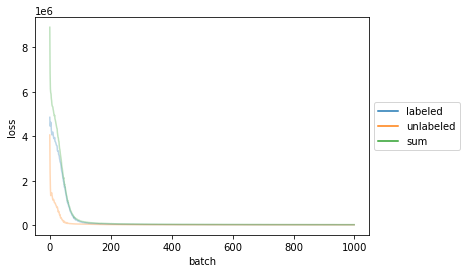

In [11]:
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[4][0] for item in loss_history]

# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

g = sns.lineplot(
    x="batch", y="loss",
    data=loss_df,
    hue="type",
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [12]:
len(labeled_total_loss)

1000

# **Inspect the output**

## TSNE unseen data (0th augmentation)

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.564376
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.877205
[t-SNE] KL divergence after 300 iterations: 1.616917
t-SNE done! Time elapsed: 4.883381128311157 seconds
(1000, 2)
(1000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

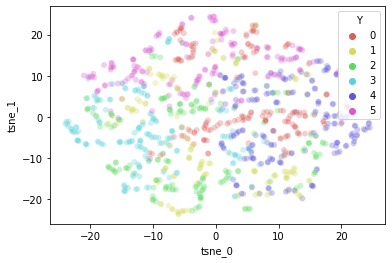

In [13]:
# plot proportions on unseen DATA
X_temp = X_full[idx_0,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_0,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



## TSNE unlabeled data  (30 degrees)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.403960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.118118
[t-SNE] KL divergence after 300 iterations: 1.371266
t-SNE done! Time elapsed: 0.9297020435333252 seconds
(1000, 2)
(1000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

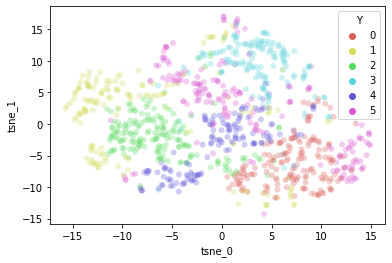

In [14]:
# plot proportions on unlabeled DATA
X_temp = X_full[idx_3,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_3,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



## TSNE All data (0-75)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 4.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.556000
[t-SNE] KL divergenc

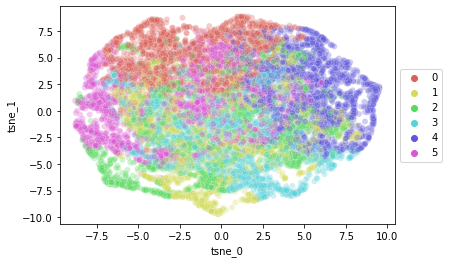

In [15]:
# plot proportions on ALL DATA
X_temp = X_full

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))



(12000, 2)
(12000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

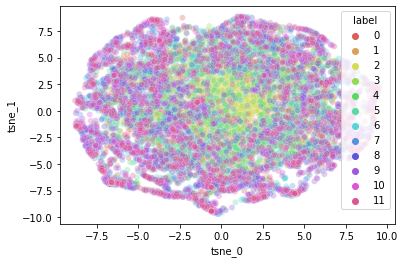

In [16]:
# plot rotations on digit embedding
# to see if rotation+digit are entangled
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 4.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 2.047769
[t-SNE] KL divergenc

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

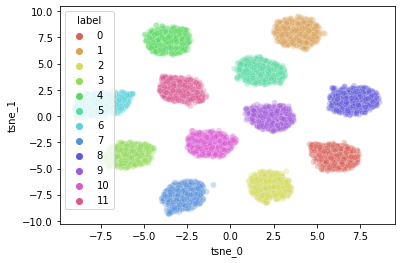

In [17]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)

(12000, 2)
(12000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

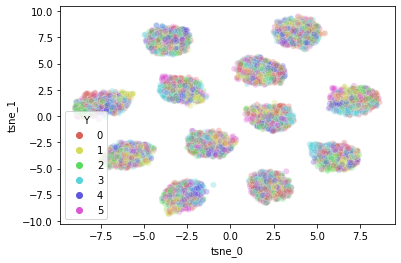

In [18]:
# plot digits on rotation embedding
# to see if rotation+digit are entangled

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)

## TSNE Training data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.621754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.196411
[t-SNE] KL divergence after 300 iterations: 3.123351
t-SNE done! Time elapsed:

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

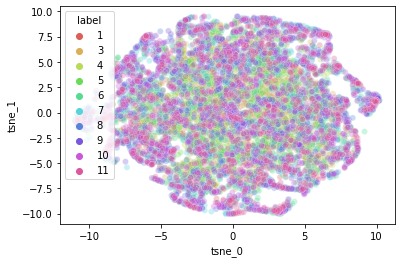

In [19]:
# plot proportion latent space of training data
X_temp = X_full[idx_train,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)




(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

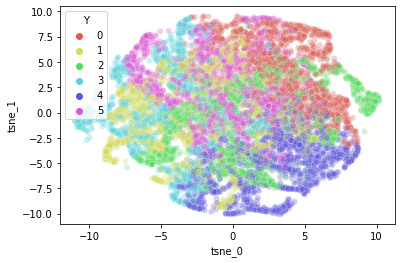

In [20]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)





/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.037378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.540321
[t-SNE] KL divergence after 300 iterations: 2.887560
t-SNE done! Time elapsed:

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

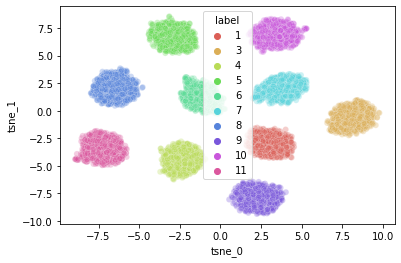

In [21]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

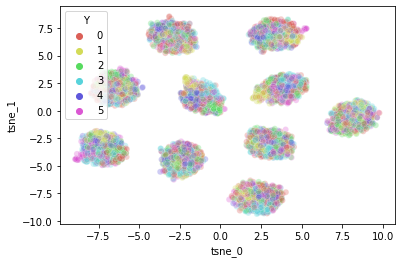

In [22]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 1.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.551417
[t-SNE] KL divergence after 50 iterations with early exaggeration: 94.466164
[t-SNE] KL divergence after 300 iterations: 2.949031
t-SNE done! Time elapsed: 

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

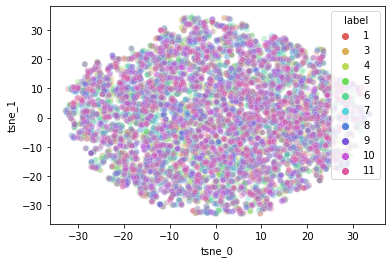

In [23]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

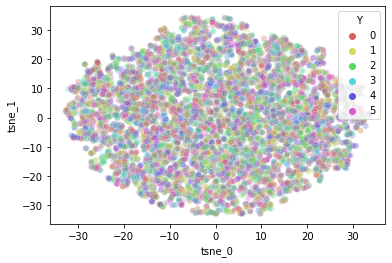

In [24]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
